In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
from random import seed # for setting seed
import tensorflow
from IPython import sys_info
import os
import gc # garbage collection
import random
import os
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
from tensorflow.python.client import device_lib
# print out the CPUs and GPUs
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 805581838599857867
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 21991653376
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2262484041582785063
physical_device_desc: "device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [ ]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [ ]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models, optimizers



In [ ]:
folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP100_ARTISTS_WITH_ALL_PICTURES'

# List the files in the folder
all_pictures = os.listdir(folder)

file_path = "/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP100_ARTISTS_WITH_ALL_PICTURES.csv"
df = pd.read_csv(file_path)

# All date to int
df['date'] = df['date'].str.replace('c.', '').astype('int', errors='ignore')

print(df.head())


                    artist  date                 genre  pixelsx  pixelsy  \
0          Ivan Aivazovsky  1873                marina   7444.0   5811.0   
1                   Titian  1562         self-portrait   4524.0   6018.0   
2  Lucas Cranach the Elder  1534  allegorical painting   4344.0   6240.0   
3             Odilon Redon  1910     literary painting   4500.0   5738.0   
4           William Turner  1839                marina   5684.0   4226.0   

   size_bytes   source                         style  \
0   3189597.0  wikiart                   Romanticism   
1   8847626.0  wikiart  Mannerism (Late Renaissance)   
2  11276229.0  wikiart          Northern Renaissance   
3   2707505.0  wikiart                     Symbolism   
4   5103820.0  wikiart                   Romanticism   

                                               title    artist_group  \
0                                       Storm at sea  train_and_test   
1                                      Self-portrait  train_an

In [ ]:
# GROUP THE FILES BY EACH ARTIST
def group_files_per_artist():
  data_per_artist = {}

  # Iterate over each row of the DataFrame
  for index, row in df.iterrows():
      artist = row['artist']
      new_filename = row['new_filename']

      # Check if the artist is already in the dictionary
      if artist in data_per_artist:
          # Add the new_filename to the existing list of the artist
          data_per_artist[artist].append(new_filename)
      else:
          # Create a new list for the artist and add the new_filename
          data_per_artist[artist] = [new_filename]

  return data_per_artist

# SPLIT THE FILES INTO TRAIN AND TEST SETS (CREATE NEW DATASETS)
def split_test_train(data_per_artist, train_percentage = 0.8):

  TRAIN_names = []
  TEST_names = []

  # Iterate over each artist and their 'new_filename'
  for artist, filenames in data_per_artist.items():
      # Calculate the number of files for training and testing
      total_files = len(filenames)
      num_train = int(train_percentage * total_files)

      # Shuffle the filenames to avoid selection biases
      random.shuffle(filenames)

      # Divide the filenames into train and test
      train_filenames = filenames[:num_train]
      test_filenames = filenames[num_train:]

      # Store the divided filenames into train and test
      TRAIN_names.extend(train_filenames)
      TEST_names.extend(test_filenames)
  return TRAIN_names, TEST_names



# CREATE TEST and TRAIN folders
def create_train_test_folders(folder, TRAIN_names, TEST_names):
    # Output folder for TRAIN and TEST
    train_folder = os.path.join(folder, 'TRAIN')
    test_folder = os.path.join(folder, 'TEST')

    # Create TRAIN and TEST folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Move images from TRAIN to TRAIN folder
    for filename in TRAIN_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(train_folder, filename)
        shutil.move(src, dst)

    # Move images from TEST to TEST folder
    for filename in TEST_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(test_folder, filename)
        shutil.move(src, dst)

    # Create df_train with rows whose 'new_filename' is in TRAIN_names and keep only 'artist' and 'new_filename' columns
    train_dataframe = df[df['new_filename'].isin(TRAIN_names)][['artist', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'train_dataframe.csv')
    # Save the DataFrame as CSV
    train_dataframe.to_csv(file_path, index=False)

    # Create df_test with rows whose 'new_filename' is in TEST_names and keep only 'artist' and 'new_filename' columns
    test_dataframe = df[df['new_filename'].isin(TEST_names)][['artist', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'test_dataframe.csv')
    # Save the DataFrame as CSV
    test_dataframe.to_csv(file_path, index=False)

    return train_dataframe, test_dataframe

if not (os.path.exists(os.path.join(folder, 'TRAIN')) and os.path.exists(os.path.join(folder, 'TEST'))):
  # Group files per artist
  data_per_artist = group_files_per_artist()
  # Print the number of files for each artist
  print("- Artists and numer of images:")
  for key in data_per_artist.keys():
    print(key, len(data_per_artist[key]))

  # Split data
  TRAIN_names, TEST_names = split_test_train(data_per_artist)

  # Use the function to create TRAIN and TEST folders
  train_dataframe, test_dataframe = create_train_test_folders(folder, TRAIN_names, TEST_names)
  print("\nImages successfully moved to TRAIN and TEST folders.")

  print("TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...")

  # Read train and test DataFrames from CSV files
  train_csv_path = os.path.join(folder, 'train_dataframe.csv')
  test_csv_path = os.path.join(folder, 'test_dataframe.csv')
  train_dataframe = pd.read_csv(train_csv_path)
  test_dataframe = pd.read_csv(test_csv_path)

  print("Train DataFrame:", train_dataframe.shape)
  print("Test DataFrame:", test_dataframe.shape)

# Create the TEST and TRAIN sets

In [ ]:
# Function to read filenames from a folder and return a list of filenames
def get_filenames_from_folder(folder_path):
    filenames = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return filenames

# Check if the TRAIN and TEST folders exist
if os.path.exists(os.path.join(folder, 'TRAIN')) and os.path.exists(os.path.join(folder, 'TEST')):
    print("TRAIN and TEST folders exist. Reading image filenames...")

    # Get filenames from the TRAIN and TEST folders
    train_filenames = get_filenames_from_folder(os.path.join(folder, 'TRAIN'))
    test_filenames = get_filenames_from_folder(os.path.join(folder, 'TEST'))

    # Filter the df DataFrame to get the train and test DataFrames
    train_dataframe = df[df['new_filename'].isin(train_filenames)][['artist','date', 'new_filename']]
    test_dataframe = df[df['new_filename'].isin(test_filenames)][['artist','date', 'new_filename']]

    print("Train DataFrame:", train_dataframe.shape)
    print("Test DataFrame:", test_dataframe.shape)
else:
    print("TRAIN and TEST folders do not exist. Please create the folders and try again.")

TRAIN and TEST folders exist. Reading image filenames...
Train DataFrame: (23057, 3)
Test DataFrame: (5808, 3)


In [ ]:
train_dataframe.head()

,artist,date,new_filename
1,Titian,1562,15715.jpg
2,Lucas Cranach the Elder,1534,77921.jpg
3,Odilon Redon,1910,29331.jpg
4,William Turner,1839,56906.jpg
7,Ivan Aivazovsky,1850,81750.jpg


In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

def get_meanstd(df, image_dir):
    means = []
    stds = []

    # Use torchvision.transforms to handle image conversion
    transform = transforms.ToTensor()  # Converts images to PyTorch tensors and scales pixel values to [0, 1]
    it=0
    for idx, row in df.iterrows():
        it+=1
        print(it)
        img_path = os.path.join(image_dir, row['new_filename'])
        img = Image.open(img_path).convert("RGB")  # Ensure the image is in RGB mode
        img = transform(img).cuda()  # Move tensor to GPU

        means.append(torch.mean(img, dim=(1, 2)).cpu().numpy())
        stds.append(torch.std(img, dim=(1, 2)).cpu().numpy())

    if len(means) == 0 or len(stds) == 0:
        raise ValueError("No valid images were found or converted to 3 channels.")

    means = np.array(means)
    stds = np.array(stds)

    meanR = np.mean(means[:, 0])
    meanG = np.mean(means[:, 1])
    meanB = np.mean(means[:, 2])

    stdR = np.mean(stds[:, 0])
    stdG = np.mean(stds[:, 1])
    stdB = np.mean(stds[:, 2])

    return [meanR, meanG, meanB], [stdR, stdG, stdB]

# Usage example (assuming train_dataframe and folder variables are defined)
means, stds = get_meanstd(train_dataframe, os.path.join(folder, "TRAIN"))
print(f'Mean Values: {means}')
print(f'STD Values: {stds}')


Se han truncado las últimas 5000 líneas del flujo de salida.
18060
18061
18062
18063
18064
18065
18066
18067
18068
18069
18070
18071
18072
18073
18074
18075
18076
18077
18078
18079
18080
18081
18082
18083
18084
18085
18086
18087
18088
18089
18090
18091
18092
18093
18094
18095
18096
18097
18098
18099
18100
18101
18102
18103
18104
18105
18106
18107
18108
18109
18110
18111
18112
18113
18114
18115
18116
18117
18118
18119
18120
18121
18122
18123
18124
18125
18126
18127
18128
18129
18130
18131
18132
18133
18134
18135
18136
18137
18138
18139
18140
18141
18142
18143
18144
18145
18146
18147
18148
18149
18150
18151
18152
18153
18154
18155
18156
18157
18158
18159
18160
18161
18162
18163
18164
18165
18166
18167
18168
18169
18170
18171
18172
18173
18174
18175
18176
18177
18178
18179
18180
18181
18182
18183
18184
18185
18186
18187
18188
18189
18190
18191
18192
18193
18194
18195
18196
18197
18198
18199
18200
18201
18202
18203
18204
18205
18206
18207
18208
18209
18210
18211
18212
18213
18214
18215
182

*HISTOGRAMA*


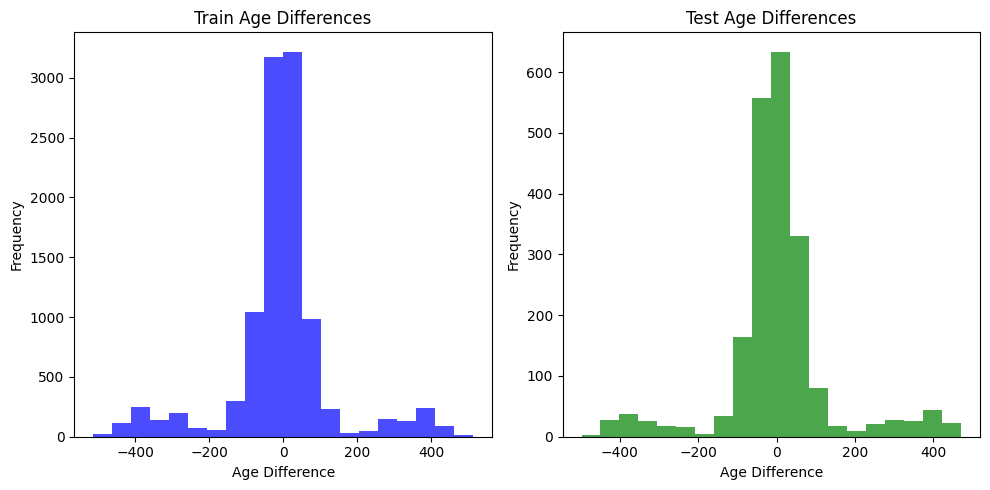

In [ ]:
import random
import itertools
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def create_pairs_by_artist(df, mode):
    pairs = []
    labels = []
    age_differences = []
    artists = df['artist'].unique()

    if mode == "TRAIN":
        num_images_per_artist = 15
    elif mode == "TEST":
        num_images_per_artist = 7
    else:
        raise ValueError("Invalid mode. Mode must be 'TRAIN' or 'TEST'.")

    for _ in range(100):
        selected_images = []
        dates_list=[]
        # Select random images from different artists
        while len(selected_images) < num_images_per_artist:
            artist = random.choice(artists)
            artist_df = df[df['artist'] == artist]
            selected_image = artist_df.sample(n=1, random_state=42)
            while selected_image['date'] in dates_list:
             selected_image = artist_df.sample(n=1, random_state=42)
            selected_images.append(selected_image)

        selected_images = pd.concat(selected_images)

        # Generate all possible pairs from the selected images
        artist_pairs = list(itertools.combinations(selected_images['new_filename'].tolist(), 2))

        for pair in artist_pairs:
            date_img1 = selected_images[selected_images['new_filename'] == pair[0]]['date'].values[0]
            date_img2 = selected_images[selected_images['new_filename'] == pair[1]]['date'].values[0]

            pairs.append([pair[0], pair[1]])
            label = 1 if date_img1 > date_img2 else 0
            labels.append(label)

            # Calculate and store age difference
            age_difference = (float(date_img1) - float(date_img2))
            age_differences.append(age_difference)

    return pairs, labels, age_differences

# Create training pairs
train_pairs, train_labels, train_age_differences = create_pairs_by_artist(train_dataframe, mode="TRAIN")

# Create test pairs
test_pairs, test_labels, test_age_differences = create_pairs_by_artist(test_dataframe, mode="TEST")

# Plot histograms of age differences
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(train_age_differences, bins=20, color='blue', alpha=0.7)
plt.title('Train Age Differences')
plt.xlabel('Age Difference')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(test_age_differences, bins=20, color='green', alpha=0.7)
plt.title('Test Age Differences')
plt.xlabel('Age Difference')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
count=0
for i in train_age_differences:
  if i==0:
    count+=1
print(count)
print(len(train_age_differences))


195
10500


**CALCULAR EL TRAIN**

In [ ]:
import random
import itertools
import os
import numpy as np
from PIL import Image
import pandas as pd

def load_image(image_path, means=None, stds=None):
    image = Image.open(image_path)
    image = np.array(image) / 255.0  # Normalize

    # Normalize using means and stds
    if means is not None and stds is not None:
        image = (image - means) / stds

    return image

def create_pairs_by_artist(df, image_dir, means, stds, mode):
    pairs = []
    labels = []
    age_differences = []
    artists = df['artist'].unique()

    if mode == "TRAIN":
        num_images_per_artist = 15
    elif mode == "TEST":
        num_images_per_artist = 7
    else:
        raise ValueError("Invalid mode. Mode must be 'TRAIN' or 'TEST'.")

    for _ in range(100):
        selected_images = []

        # Select random images from different artists
        while len(selected_images) < num_images_per_artist:
            artist = random.choice(artists)
            artist_df = df[df['artist'] == artist]
            selected_image = artist_df.sample(n=1, random_state=78)
            selected_images.append(selected_image)

        selected_images = pd.concat(selected_images)

        # Generate all possible pairs from the selected images
        artist_pairs = list(itertools.combinations(selected_images['new_filename'].tolist(), 2))

        for pair in artist_pairs:
            date_img1 = selected_images[selected_images['new_filename'] == pair[0]]['date'].values[0]
            date_img2 = selected_images[selected_images['new_filename'] == pair[1]]['date'].values[0]

            img1_path = os.path.join(image_dir, pair[0])
            img2_path = os.path.join(image_dir, pair[1])

            img1 = load_image(img1_path, means=means, stds=stds)  # Load and normalize image 1
            img2 = load_image(img2_path, means=means, stds=stds)  # Load and normalize image 2

            pairs.append([img1, img2])
            label = 1 if date_img1 > date_img2 else 0
            labels.append(label)
            del img1, img2

    return np.array(pairs), np.array(labels)

# Create training pairs
train_pairs, train_labels = create_pairs_by_artist(train_dataframe, os.path.join(folder, "TRAIN"), means, stds, mode="TRAIN")

# Create test pairs
test_pairs, test_labels = create_pairs_by_artist(test_dataframe, os.path.join(folder, "TEST"), means, stds, mode="TEST")






KeyError: 'artist'

In [ ]:
print("Number of pairs in TRAIN:", len(train_pairs))
print("Number of pairs in TEST:", len(test_pairs))

Number of pairs in TRAIN: 10500
Number of pairs in TEST: 2100


In [ ]:
from torchvision import transforms

train_dataframe = train_dataframe.drop(columns=['artist'])
test_dataframe = test_dataframe.drop(columns=['artist'])
# Data Transformation

# Transformations for training set
train_transformer = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomVerticalFlip(p=0.5),
                                        transforms.ToTensor(),
                                        transforms.Normalize([means[0], means[1], means[2]],
                                                             [stds[0], stds[1], stds[2]])])

# Standard transformations for test set
test0_transformer = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize([means[0], means[1], means[2]],
                                                             [stds[0], stds[1], stds[2]])])

# Update the transform functions for train_ds & test_all
train_dataframe.transform = train_transformer
test_dataframe.transform = test0_transformer

In [ ]:
# Plotting the training and validation curves for loss and accuracy
def plot_out(loss_hist, metric_hist, epochs=None):
    # Create the figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Loss history plot
    axs[0].plot(range(1, epochs+1), loss_hist["train"], label="Train loss")
    axs[0].plot(range(1, epochs+1), loss_hist["val"], label="Validation loss")
    axs[0].set_title('Loss History')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Metric history plot
    axs[1].plot(range(1, epochs+1), metric_hist["train"], label="Train accuracy")
    axs[1].plot(range(1, epochs+1), metric_hist["val"], label="Validation accuracy")
    axs[1].set_title('Accuracy History')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:

1

1

## The best model of Vgg with early stopping of val_accuracy

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks

input_shape = (224, 224, 3)
learning_rate = 1e-4

def create_model(input_shape):
    base_model = tf.keras.applications.VGG16(include_top=False, input_shape=input_shape, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-4:]:
        layer.trainable = True

    input_1 = layers.Input(shape=input_shape)
    input_2 = layers.Input(shape=input_shape)

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = layers.Flatten()(x1)
    x2 = layers.Flatten()(x2)

    concatenated = layers.Concatenate()([x1, x2])

    dense = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01))(concatenated)
    dense = layers.Dropout(0.6)(dense)  # Increased dropout rate
    dense = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01))(dense)
    dense = layers.Dropout(0.6)(dense)  # Increased dropout rate
    output = layers.Dense(1, activation='sigmoid')(dense)

    model = models.Model(inputs=[input_1, input_2], outputs=output)

    optimizer = optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_model(input_shape)
model.summary()
# Early stopping and learning rate reduction
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# Training the model
history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels,
                    epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

# Evaluating the model
test_loss, test_accuracy = model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f'Test accuracy: {test_accuracy:.2f}')


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_2[0][0]',             
                                                          8          'input_3[0][0]']             
                                                                                                  
 flatten (Flatten)           (None, 25088)                0         ['vgg16[0][0]']           

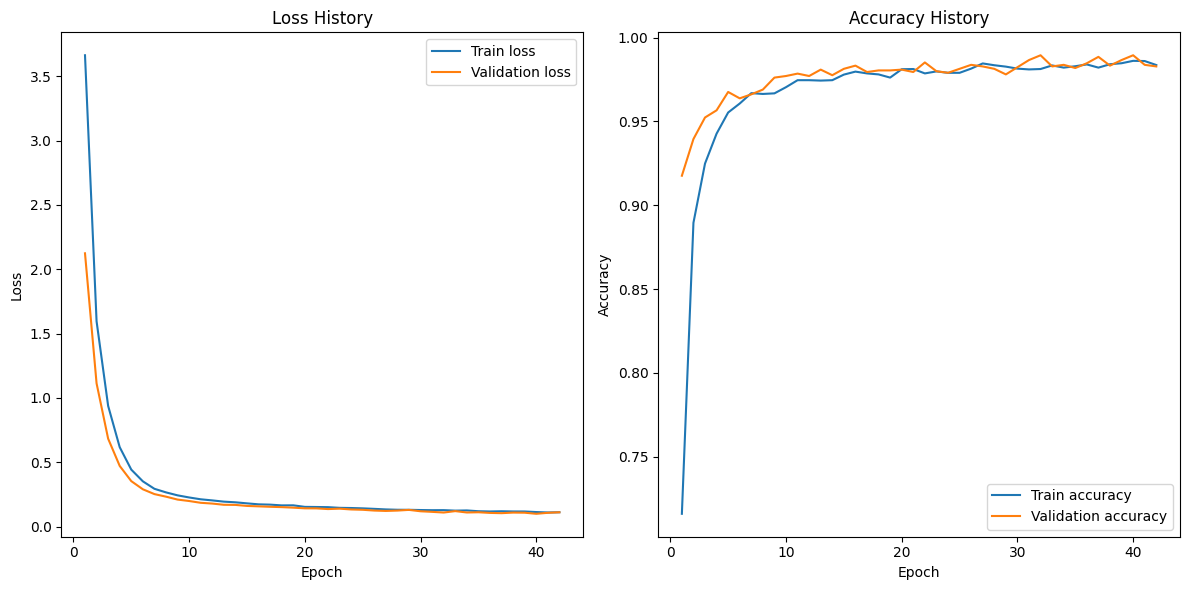

In [ ]:
# Prepare the data for the plot_out function
loss_hist = {
    "train": history.history['loss'],
    "val": history.history['val_loss']
}

metric_hist = {
    "train": history.history['accuracy'],
    "val": history.history['val_accuracy']
}

# Call the plot_out function
plot_out(loss_hist, metric_hist, epochs=len(history.history['loss']))

**GUARDAR MODELO**

In [ ]:
model.save("/content/drive/My Drive/PROJECTE DEEP LEARNING/vgg16_Order_by_data.h5")


In [ ]:
# Cargar el modelo entrenado
modelo_cargado = tf.keras.models.load_model("/content/drive/My Drive/PROJECTE DEEP LEARNING/vgg16_Order_by_data.h5")
test_loss, test_accuracy = modelo_cargado.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)


66/66 [==============================] - 13s 194ms/step - loss: 0.9413 - accuracy: 0.6205


In [ ]:
import torch

# Supongamos que tu modelo se llama "pre_densenet201"
torch.save(model.state_dict(), "vgg_weights.pth")


AttributeError: 'Functional' object has no attribute 'state_dict'

**RESNET18**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks

# Define input shape and learning rate
input_shape = (224, 224, 3)
learning_rate = 1e-4

# Función para crear el modelo ResNet18
def residual_block(x, filters, strides=1, activation='relu'):
    shortcut = x

    # Primera capa convolucional
    x = layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    # Segunda capa convolucional
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Si el número de filtros o la forma de entrada cambian, ajustar la conexión shortcut
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Agregar la conexión shortcut
    x = layers.Add()([x, shortcut])
    x = layers.Activation(activation)(x)

    return x

def create_resnet18(input_shape):
    inputs1 = layers.Input(shape=input_shape)
    inputs2 = layers.Input(shape=input_shape)

    # Primera rama del modelo
    x1 = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x1)

    x1 = residual_block(x1, 64, strides=1)
    x1 = residual_block(x1, 64, strides=1)

    x1 = residual_block(x1, 128, strides=2)
    x1 = residual_block(x1, 128, strides=1)

    x1 = residual_block(x1, 256, strides=2)
    x1 = residual_block(x1, 256, strides=1)

    x1 = residual_block(x1, 512, strides=2)
    x1 = residual_block(x1, 512, strides=1)

    # Segunda rama del modelo
    x2 = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Activation('relu')(x2)
    x2 = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x2)

    x2 = residual_block(x2, 64, strides=1)
    x2 = residual_block(x2, 64, strides=1)

    x2 = residual_block(x2, 128, strides=2)
    x2 = residual_block(x2, 128, strides=1)

    x2 = residual_block(x2, 256, strides=2)
    x2 = residual_block(x2, 256, strides=1)

    x2 = residual_block(x2, 512, strides=2)
    x2 = residual_block(x2, 512, strides=1)

    # Concatenar las salidas de las dos ramas
    concatenated = layers.Concatenate()([x1, x2])

    x = layers.GlobalAveragePooling2D()(concatenated)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.6)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model([inputs1, inputs2], outputs)
    return model

# Crear el modelo ResNet18
model = create_resnet18(input_shape)
model.summary()

# Compilar el modelo
optimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Definir callback para detener el entrenamiento temprano si no hay mejoras en la precisión de la validación
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels,
                    epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping])

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate([test_pairs[:, 0], test_pairs[:, 1]], test_labels)
print(f'Test accuracy: {test_accuracy:.2f}')


In [ ]:
# Obtener el historial de pérdida y métricas del entrenamiento
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']

# Crear los diccionarios para pasar a la función de trazado
loss_hist = {"train": loss_history, "val": val_loss_history}
metric_hist = {"train": accuracy_history, "val": val_accuracy_history}

# Llamar a la función de trazado
plot_out(loss_hist, metric_hist, epochs=len(loss_history))